In [1]:
# Copyright (C) 2016-2018 by Jakob J. Kolb at Potsdam Institute for Climate
# Impact Research
#
# Contact: kolb@pik-potsdam.de
# License: GNU AGPL Version 3
%matplotlib notebook
import PyDSTool as pdt
import numpy as np
import networkx as nx
from random import shuffle
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pydivest.macro_model.integrate_equations_aggregate import IntegrateEquationsAggregate as Model

In [2]:
b_ds = [round(x, 5) for x in list(np.linspace(1., 4., 21))]
kappa_cs = [round(x, 5) for x in list(np.linspace(.4, .5, 2))]
d_cs = [round(x, 5) for x in list(np.linspace(.05, .12, 8))]
es = [round(x, 5) for x in list(np.linspace(1., 51, 3))]
b_Rs = [round(x, 5) for x in list(np.linspace(.1, .5, 3))]
epss = [round(x, 5) for x in list(np.linspace(.01, .05, 3))]

columns = ['x', 'xi', 'C', 'labels', 'stability']

with pd.HDFStore('../output_data/P8/P8.h5') as store:
    df = store.select('dat', columns=columns)
#     print(store.info())

for col in df.columns[:-2]:
    df[col] = df[col].astype(float)
df = df.loc[df['C'] < 150000]

In [3]:
df.index.levels

FrozenList([[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], [0.5], [0.12], [1.0], [0.1], [0.01], [0.0, 0.2, 0.4, 0.6, 0.8], [False], [0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]])

<IPython.core.display.Javascript object>


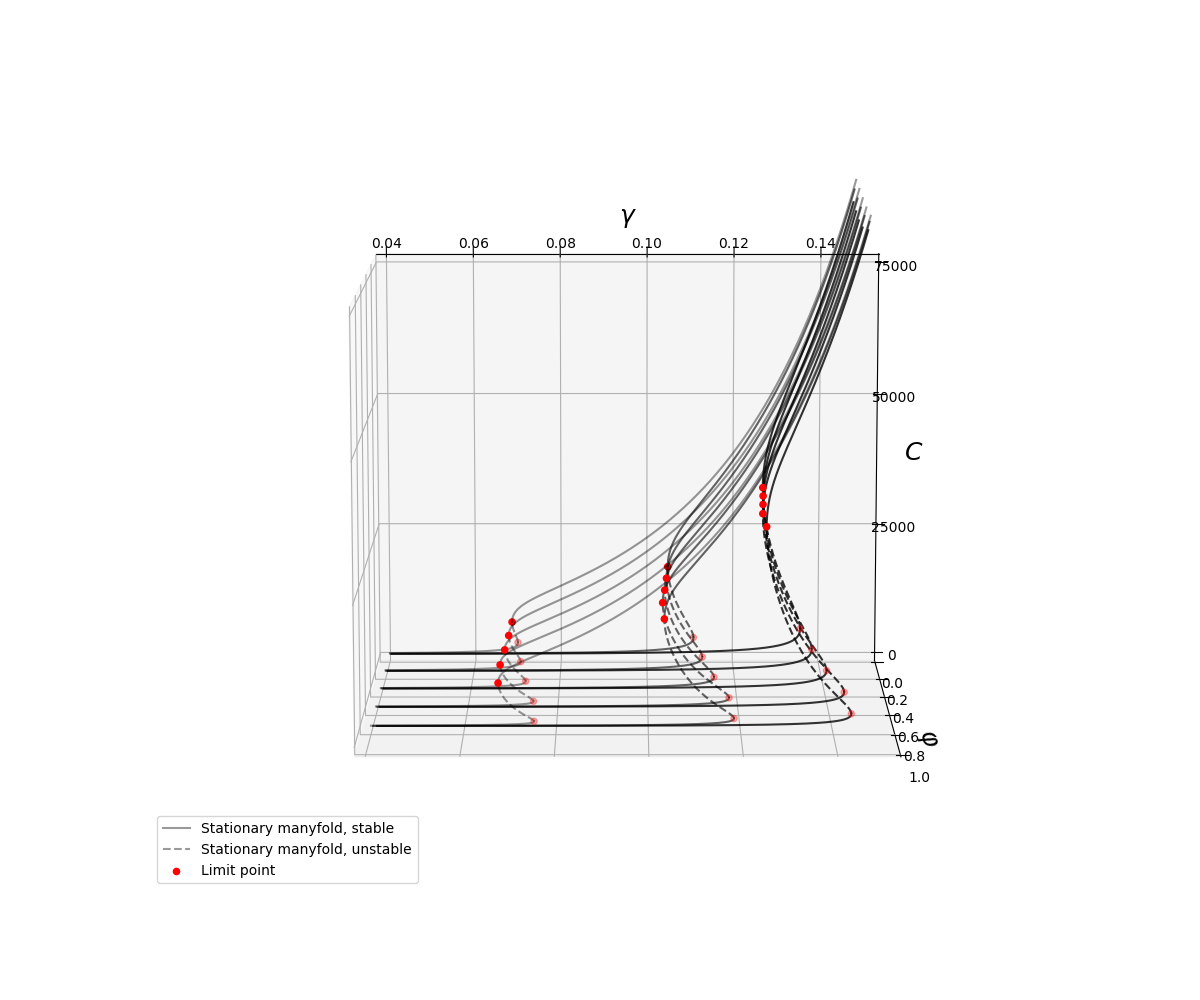

0.0
0.2
0.4
0.6
0.8
0.0
0.2
0.4
0.6
0.8
0.0
0.2
0.4
0.6
0.8


In [4]:
# import 3d plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

# create 3d figure and axes
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

def plotit(df, phi, ax, style, alpha=1):
    df_lines = df.set_index('xi')['C']
    x = df_lines.index.values 
    y = df_lines.values
    z = phi
    ax.plot(x, y, z, style, color='black', alpha=alpha, zdir='z')

# plot for each value of phi
for b_d in [2, 3, 4]:
    for phi in df.index.levels[6]:
        print(phi)

        # select data according to phi value
        df_plt = df.xs(key=(b_d, phi), level=(0, 6))

        # if there are limit points, (labelled with 'EP, LP'), plot stationary manyfold in parts
        # with style according to stability
        C_lps = df_plt.loc[df_plt['labels']=='EP, LP', 'C'].values
        if len(C_lps) > 0:
            C_cut = C_lps[0]
            plotit(df_plt.loc[(df_plt['stability']=='S') & (df_plt['C'] < C_cut)], phi, ax, '-', alpha=b_d/10.*2)
            plotit(df_plt.loc[(df_plt['stability']=='S') & (df_plt['C'] > C_cut)], phi, ax, '-', alpha=b_d/10.*2)
            plotit(df_plt.loc[(df_plt['stability']=='N')], phi, ax, '--', alpha=b_d/10.*2)

        # else, plot it in one piece
        else:
            plotit(df_plt, phi, ax, '-')

        # select data for limit points and plot them as red dots.
        df_lp = df_plt.loc[df_plt['labels']=='EP, LP']
        if len(df_lp['C'].values)>0:
            x = df_lp['xi'].values
            y = df_lp['C'].values
            z = phi
            ax.scatter(x, y, z, color='red', zdir='z')
        
# generate legend
x, y, z = (-10, -10, -10)
xs, ys = np.zeros((2, 10))
ax.plot(xs, ys, z, '-', color='black', alpha=0.4, label='Stationary manyfold, stable')
ax.plot(xs, ys, z, '--', color='black', alpha=0.4, label='Stationary manyfold, unstable')
ax.scatter(x, y, z, color='red', zdir='z', label='Limit point')

plt.legend(loc=3)

# set axis ticks and limits
#ax.set_zticks([1, 2.5, 4])
ax.set_zlim([0, 1])
ax.set_yticks([0, 25000, 50000, 75000])
ax.set_ylim([0, 75000])
ax.set_xlim([0.04, 0.151])

# set rotation
ax.azim = -90
ax.elev = 100

# set axis labels. would like to ratete the, but doesn't seem to work..
ax.set_xlabel(r'$\gamma$', fontsize=18)
ax.set_ylabel(r'$C$', fontsize=18)
ax.set_zlabel(r'$\varphi$', fontsize=18)

# ax.show()
# df_lp = df.loc[df['labels'] == 'EP, LP']

# idx = df_lp.groupby('phi')['C'].transform(max) == df_lp['C']
# df_lp_max = df_lp[idx][['xi', 'C']]
# df_lp_max.columns = ['xi', 'Limit Point \ncurve']
# # ToDo Plot 3d
# df_lp_max.set_index('xi').plot(ax=ax, color='red')

# idx = df_lp.groupby('phi')['C'].transform(min) == df_lp['C']
# # ToDo Plot 3d
# df_lp[idx][['xi', 'C']].set_index('xi').plot(ax=ax, color='red', legend=False)

fig.savefig('cusp_phi_bd_v1.pdf')

<IPython.core.display.Javascript object>


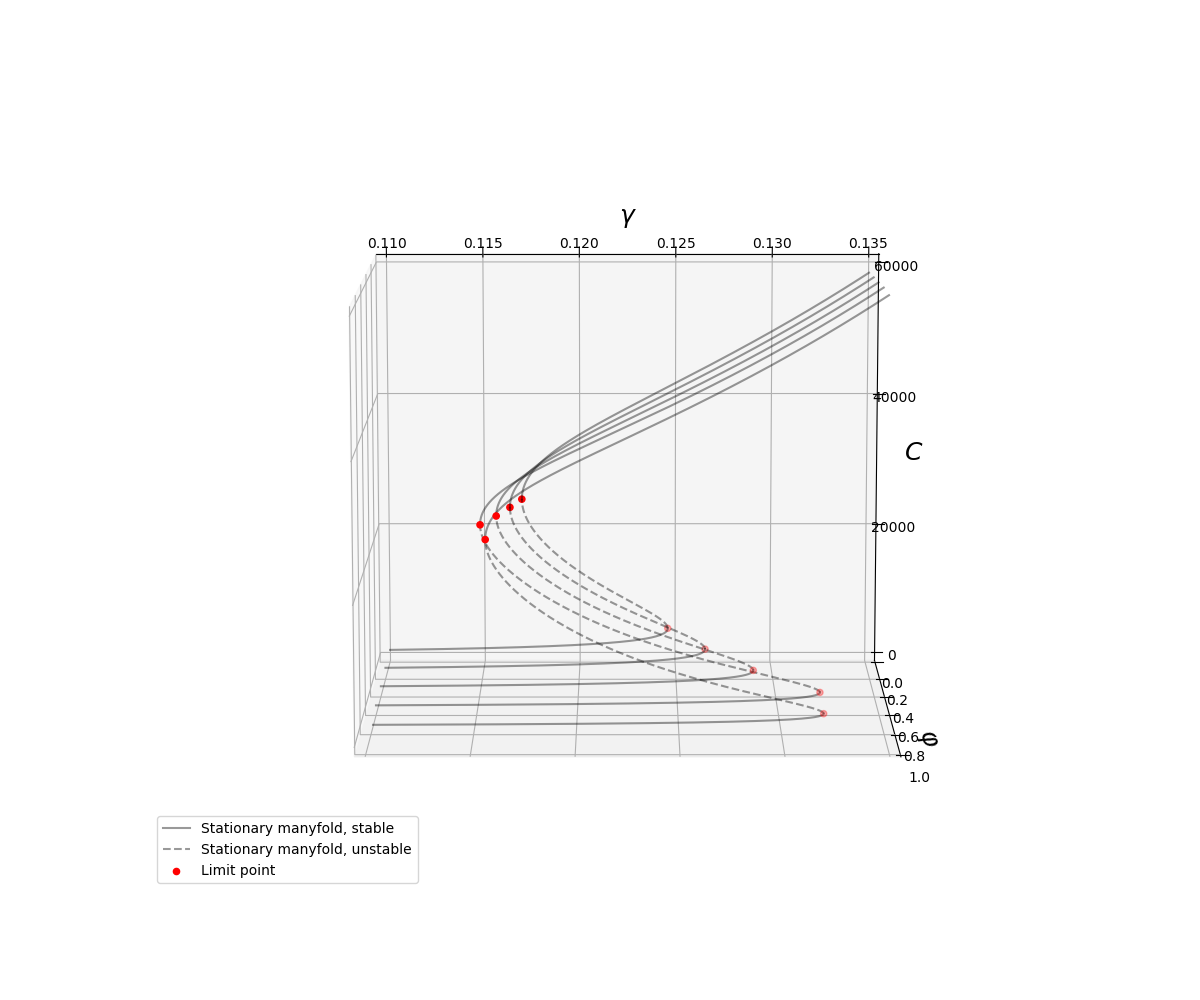

0.0
0.2
0.4
0.6
0.8


In [10]:
# import 3d plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

# create 3d figure and axes
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

def plotit(df, phi, ax, style):
    df_lines = df.set_index('xi')['C']
    x = df_lines.index.values
    y = df_lines.values
    z = phi
    ax.plot(x, y, z, style, color='black', alpha=0.4, zdir='z')

# plot for each value of phi

xi_max = 0.135
xi_min = 0.11

b_d = 3.5
for phi in df.index.levels[6]:
    print(phi)

    # select data according to phi value
    df_plt = df.xs(key=(b_d, phi), level=(0, 6))
    df_plt = df_plt.loc[(df_plt['xi']<xi_max) & (df_plt['xi']>xi_min)]

    # if there are limit points, (labelled with 'EP, LP'), plot stationary manyfold in parts
    # with style according to stability
    C_lps = df_plt.loc[df_plt['labels']=='EP, LP', 'C'].values
    if len(C_lps) > 0:
        C_cut = C_lps[0]
        plotit(df_plt.loc[(df_plt['stability']=='S') & (df_plt['C'] < C_cut)], phi, ax, '-')
        plotit(df_plt.loc[(df_plt['stability']=='S') & (df_plt['C'] > C_cut)], phi, ax, '-')
        plotit(df_plt.loc[(df_plt['stability']=='N')], phi, ax, '--')

    # else, plot it in one piece
    else:
        plotit(df_plt, phi, ax, '-')

    # select data for limit points and plot them as red dots.
    df_lp = df_plt.loc[df_plt['labels']=='EP, LP']
    if len(df_lp['C'].values)>0:
        x = df_lp['xi'].values
        y = df_lp['C'].values
        z = phi
        ax.scatter(x, y, z, color='red', zdir='z')
        
# generate legend
x, y, z = (-10, -10, -10)
xs, ys = np.zeros((2, 10))
ax.plot(xs, ys, z, '-', color='black', alpha=0.4, label='Stationary manyfold, stable')
ax.plot(xs, ys, z, '--', color='black', alpha=0.4, label='Stationary manyfold, unstable')
ax.scatter(x, y, z, color='red', zdir='z', label='Limit point')

plt.legend(loc=3)

# set axis ticks and limits
#ax.set_zticks([1, 2.5, 4])
ax.set_zlim([0, 1])
ax.set_yticks([0, 20000, 40000, 60000])
ax.set_ylim([0, 60000])
ax.set_xlim([xi_min,xi_max])

# set rotation
ax.azim = -90
ax.elev = 100

# set axis labels. would like to ratete the, but doesn't seem to work..
ax.set_xlabel(r'$\gamma$', fontsize=18)
ax.set_ylabel(r'$C$', fontsize=18)
ax.set_zlabel(r'$\varphi$', fontsize=18)

# ax.show()
# df_lp = df.loc[df['labels'] == 'EP, LP']

# idx = df_lp.groupby('phi')['C'].transform(max) == df_lp['C']
# df_lp_max = df_lp[idx][['xi', 'C']]
# df_lp_max.columns = ['xi', 'Limit Point \ncurve']
# # ToDo Plot 3d
# df_lp_max.set_index('xi').plot(ax=ax, color='red')

# idx = df_lp.groupby('phi')['C'].transform(min) == df_lp['C']
# # ToDo Plot 3d
# df_lp[idx][['xi', 'C']].set_index('xi').plot(ax=ax, color='red', legend=False)

fig.savefig('cusp_phi_bd_v2.pdf')